## Cellpose - Transfer learning (Intelligent)

Apply the anatomical segmentation algorithm [cellpose](https://www.cellpose.org/) to the data

In [32]:
#!pip install cellpose

# Imports

In [33]:
from cellpose import models, plot, io
from yacs.config import CfgNode as CN 
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import zoom
import tifffile
from scipy import optimize
import cv2
from tqdm import tqdm

from connectomics.data.utils import *
from connectomics.data.utils import getSegType

# Configs

In [34]:
_C = CN()

_C.ROOT = "/n/pfister_lab2/Lab/zudilin/data/NucExM/NucExM-Release"
_C.VOLUMES = ["image0.h5","image1.h5","image2.h5","image3.h5"]

_C.H5KEY = 'main'

In [35]:
def get_cfg_defaults():
    return _C.clone()

cfg = get_cfg_defaults()

In [36]:
# Best configs:
"image0.h5"
"image1.h5" : Diameter 110, flow 0.8, tresh -3, anisotropy=2
"image2.h5" : Diameter 110, flow 0.8, tresh -2, anisotropy=2 
"image3.h5" : Diameter 120, flow 1.0, tresh -4, anisotropy=2, resample=True


SyntaxError: invalid syntax (<ipython-input-36-6c4b7246b94d>, line 3)

# Utils

In [37]:
def cast2dtype(segm):
    """Cast the segmentation mask to the best dtype to save storage.
    """
    max_id = np.amax(np.unique(segm))
    m_type = getSegType(int(max_id))
    return segm.astype(m_type)

In [38]:
# load volume
def load_vol(root,vol_name):
    with h5py.File(os.path.join(root, vol_name), 'r') as h5:
        vol = np.asarray(h5.get(cfg.H5KEY))
    return vol

In [39]:
# load volume
def load_vol_tif(path):
    with tifffile.TiffFile(path) as tif:
        vol = np.asarray([img.asarray()  for img in tif.pages[:]])
    return vol

In [40]:
# plot sample result
def vis_sample(img, masks, flows, channels=[[0,0]], figsize=(12,5), save=False, path=None):
    fig = plt.figure(figsize=figsize)
    plot.show_segmentation(fig, img, masks, np.asarray(flows[0]), channels=channels)
    plt.tight_layout()
    plt.show()
    if save:
        fig.savefig(path, dpi=fig.dpi)

In [41]:
model = models.Cellpose(model_type='nuclei', gpu=True)
# gray images
channels = [[0,0]]

2022-02-26 17:40:09,682 [INFO] ** TORCH CUDA version installed and working. **
2022-02-26 17:40:09,686 [INFO] >>>> using GPU


In [42]:
diamters = [90,100,110,120]
flow_threshold = [0.4, 0.6, 0.8, 1.0]
mask_threshold = [-4, -3, -2, -1]
plot_nr = len(diamters)*len(flow)*len(mask)
fig, axes = plt.subplots(nrows=int(np.sqrt(plot_nr)), ncols=int(np.sqrt(plot_nr)), figsize=(40,40))
axes = axes.flatten()
vol = load_vol(cfg.ROOT, cfg.VOLUMES[0])[100, : , :]
plt.set_cmap("gray")
for i,d in enumerate(diamters):
    for l,f in enumerate(flow_threshold):
        for j,t in enumerate(mask_threshold):
            counter = i*len(flow_threshold)*len(mask_threshold)+l*len(mask_threshold)+j
            if counter >= plot_nr:
                break
            print(f"Counter: {counter}")
            mask, flows, styles, diams = model.eval(vol, resample=True, anisotropy=2, flow_threshold=f, mask_threshold=t, diameter=d, invert=True, channels=channels)
            axes[counter].imshow(mask)
            axes[counter].set_title(f"d: {d}, f {f}, t: {t}")


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2b8d06327830> (for post_execute):


KeyboardInterrupt: 

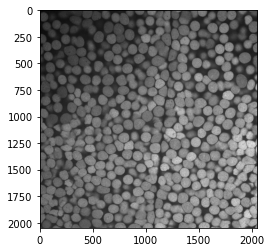

In [30]:
plt.set_cmap("gray")
plt.imshow(vol)

In [9]:
def color_grid_box(img,block_size,x1,x2,y1,y2,color=[255,0,0]):
    if not isinstance(block_size, tuple):
        if isinstance(block_size, int):
            block_size= (block_size,block_size)
        else:
            print(f"block_size must be tupel or int, but is {block_size.type}")
    img[y1*block_size[0]:y2*block_size[0],x1*block_size[1],:] = grid_color_red
    img[y1*block_size[0]:y2*block_size[0],x2*block_size[1],:] = grid_color_red
    img[y1*block_size[0],x1*block_size[1]:x2*block_size[1],:] = grid_color_red
    img[y2*block_size[0],x1*block_size[1]:x2*block_size[1],:] = grid_color_red
    return img

In [10]:
def grid_search_stardis(hyper, *params):
    vol, segs, model= params
    print(vol.shape)
    assert(vol.shape == segs.shape)
    aniso, diameter, thresh = hyper
    masks, flows, styles, diams = model.eval(vol, do_3D=True, anisotropy=aniso, diameter=diameter, mask_threshold=thresh, invert=True, channels=[[0,0]])

    assert(masks.shape == vol.shape)
    # normalize the volumes
    if np.max(masks) > 0:
        masks = ((masks - np.min(masks))/(np.max(masks)-np.min(masks))*255).astype(np.uint8)
    else:
        masks = masks.astype(np.uint8)

    if np.max(vol) > 0:
        vol = ((vol - np.min(vol))/(np.max(vol)-np.min(vol))*255).astype(np.uint8)
    else:
        vol = vol.astype(np.uint8)
    
    diff = []
    for i in range(0, (vol.shapoe)):
        img_diff = cv2.absdiff(vol[i,:,:], masks[i,:,:])
        diff.append(np.sum(img_diff))
    return np.sum(np.asarray(diff))

# Cellpose model

In [12]:
model = models.Cellpose(model_type='nuclei', gpu=True)
# gray images
channels = [[0,0]]

2022-02-26 16:47:00,249 [INFO] ** TORCH CUDA version installed and working. **
2022-02-26 16:47:00,253 [INFO] >>>> using GPU


# Inference all volumes

In [12]:
# values derived from experimenting with the sample below
diamters = [110,100,100,100]
thresholds = [-1,-2,-2,-2]
  


In [ ]:
for i, vol_name in enumerate(cfg.VOLUMES[:1]):
    vol = load_vol(cfg.ROOT, vol_name)#[100:200,:256, :256]
    #vol = zoom(vol, (1,1/4,1/4), order=3)
    masks, flows, styles, diams = model.eval(vol, do_3D=True, anisotropy=2, diameter=diamters[i], mask_threshold=thresholds[i], invert=True, channels=channels)
    # downsample the output
    final_mask_volume = np.zeros_like(masks)
    assert(masks.shape==(255,2048,2048))
    for i, mask in tqdm(enumerate(masks)):            

        # 2. downsample the image and GT mask
        # use bilinear upsampling for the images
        mask = resize(mask, (masks.shape[0], 512,512), order=0, preserve_range=True, anti_aliasing=True)

        final_mask_volume[i, :, :] = img

    final_mask_volume = cast2dtype(final_mask_volume)
    assert(final_mask_volume.dtype in ["uint16", "uint32", "uint64"]), "The input label volume should be of type uint8 | uint16 | uint32 | uint64"

    with h5py.File(os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/cellpose_ouput", "cellpose_masks"+vol_name), "w") as h5:
        h5_dataset =  h5.create_dataset("main", data=final_mask_volume)
    

2022-02-26 16:08:40,394 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:08:40,397 [INFO] multi-stack tiff read in as having 255 planes 1 channels
2022-02-26 16:09:17,191 [INFO] running YX: 255 planes of size (2048, 2048)
2022-02-26 16:09:35,990 [INFO] 3%|3         | 1/32 [00:00<00:05,  5.42it/s]


2022-02-26 16:09:41,668 [INFO] 100%|##########| 32/32 [00:05<00:00,  5.46it/s]
2022-02-26 16:09:57,042 [INFO] running ZY: 2048 planes of size (255, 2048)
2022-02-26 16:10:09,052 [INFO] 8%|7         | 10/128 [00:00<00:09, 12.12it/s]


2022-02-26 16:10:26,476 [INFO] 67%|######7   | 86/128 [00:07<00:03, 12.12it/s]


2022-02-26 16:10:41,114 [INFO] 100%|##########| 128/128 [00:10<00:00, 12.10it/s]
2022-02-26 16:11:33,851 [INFO] running ZX: 2048 planes of size (255, 2048)
2022-02-26 16:11:36,467 [INFO] 22%|##1       | 28/128 [00:02<00:08, 12.09it/s]


2022-02-26 16:11:53,745 [INFO] 81%|########1 | 104/128 [00:08<00:01, 12.14it/s]


2022-02-26 16:12:11,442 [INFO] 38%|###7      | 48/128 [00:03<00:06, 12.11it/s]


2022-02-26 16:12:18,061 [INFO] 100%|##########| 128/128 [00:10<00:00, 12.10it/s]
2022-02-26 16:13:19,782 [INFO] network run in 273.91s


In [ ]:
vis_sample(vol[50,:,:], masks[50,:,:], [flows[0][50,:,:,:]])

# Grid search

In [ ]:
label = "/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/gt_seg_mask/seg_3D_255_512_512.tif"
images = "/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/testA/em_3D_255_512_512.tif"
img = load_vol_tif(images)
lab = load_vol_tif(label)

print(img.shape)
print(lab.shape)
for i, vol_name in enumerate(cfg.VOLUMES):
    params = (load_vol_tif(images)[120:180,:512,:512], load_vol_tif(label)[120:180,:512,:512], model)
    rranges = (slice(1, 4, 1), slice(90, 120, 5), slice(-3, 3, 1))
    resbrute = optimize.brute(grid_search_stardis, rranges, args=params, full_output=True,
                          finish=optimize.fmin)

print(resbrute)

# Inference single samples 

### Sample image0.h5

In [18]:
for vol in cfg.VOLUMES[1:]:
    img0_100 = load_vol(cfg.ROOT, vol)[100, : , :]
    print(np.min(img0_100),np.max(img0_100))


0 255
16 255
8 255


In [ ]:
diamters = [110,120]
flow = [0.8, 1.0]
threshold = [-4, -3, -2, -1]
for vol in cfg.VOLUMES[2:]:
    vol = load_vol(cfg.ROOT, vol)
    #normalize volume 
    vol_norm = (vol-np.min(vol))/(np.max(vol)-np.min(vol))
    print(np.max(vol_norm), np.min(vol_norm))
    img0_100 = vol_norm[100, : , :]
    for d in diamters:
        for f in flow:
            for t in threshold:
                print(f"Diameter {d}, flow {f}, tresh {t}")
                #print(f"threshold {t}")
                masks, flows, styles, diams = model.eval(img0_100, resample=True, anisotropy=3, flow_threshold=f, mask_threshold=t, diameter=d, invert=True, channels=channels)
                plt.imshow(masks)
                break
                print(masks.dtype)
                print(masks.shape)
                #vis_sample(img0_100, masks, flows, save=False, path=os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/cellpose_ouput", vol.split(".")[0]+"_d_"+str(d)+"_t_"+ str(t)+".png"))
                vis_sample(img0_100, masks, flows)#, save=True, path=os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/cellpose_ouput", vol.split(".")[0]+"_d_"+str(d)+"_t_"+ str(t)+".png"))

Diameter 90, threshold -2, iso 0
2022-02-26 16:47:31,432 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:47:33,444 [INFO] >>>> TOTAL TIME 2.01 sec


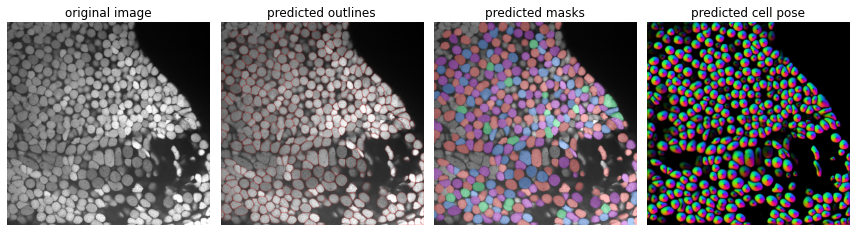

Diameter 90, threshold -2, iso 1
2022-02-26 16:47:36,878 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:47:38,791 [INFO] >>>> TOTAL TIME 1.91 sec


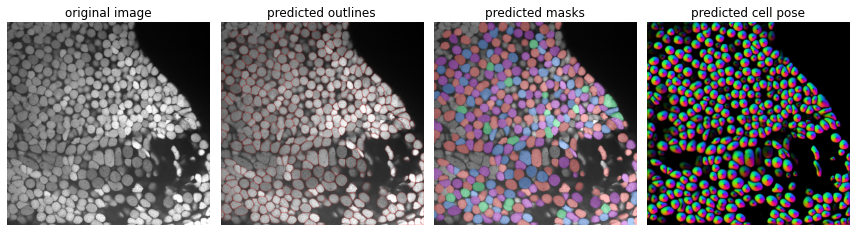

Diameter 90, threshold -2, iso 2
2022-02-26 16:47:41,796 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:47:43,744 [INFO] >>>> TOTAL TIME 1.95 sec


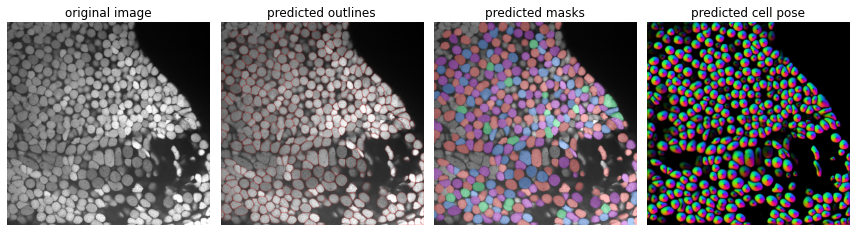

Diameter 90, threshold -2, iso 3
2022-02-26 16:47:46,755 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:47:48,613 [INFO] >>>> TOTAL TIME 1.86 sec


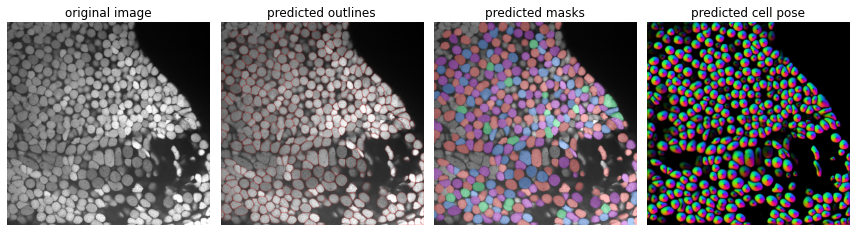

Diameter 90, threshold -1, iso 0
2022-02-26 16:47:51,720 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:47:53,578 [INFO] >>>> TOTAL TIME 1.86 sec


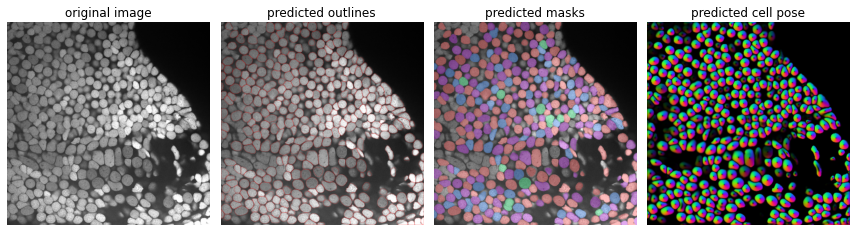

Diameter 90, threshold -1, iso 1
2022-02-26 16:47:56,738 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:47:58,626 [INFO] >>>> TOTAL TIME 1.89 sec


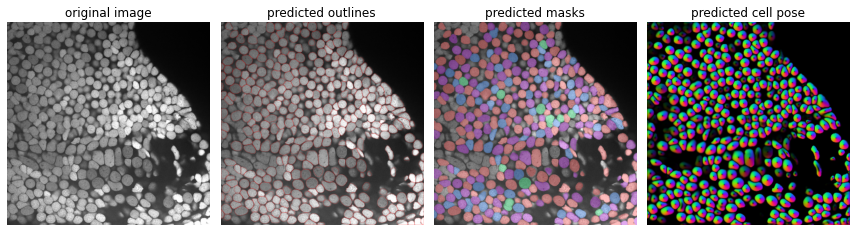

Diameter 90, threshold -1, iso 2
2022-02-26 16:48:01,673 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:48:03,562 [INFO] >>>> TOTAL TIME 1.89 sec


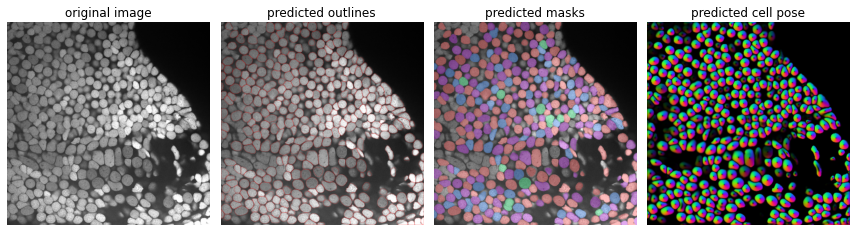

Diameter 90, threshold -1, iso 3
2022-02-26 16:48:06,640 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:48:08,577 [INFO] >>>> TOTAL TIME 1.94 sec


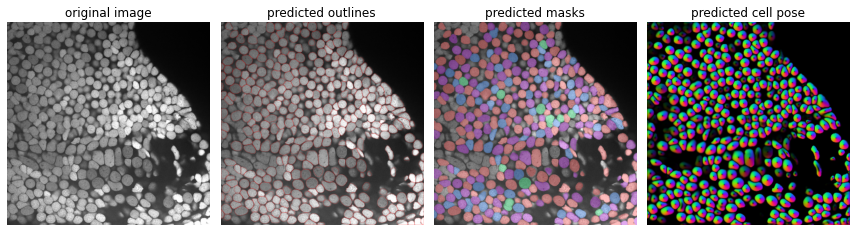

Diameter 90, threshold 0, iso 0
2022-02-26 16:48:11,586 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:48:13,463 [INFO] >>>> TOTAL TIME 1.88 sec


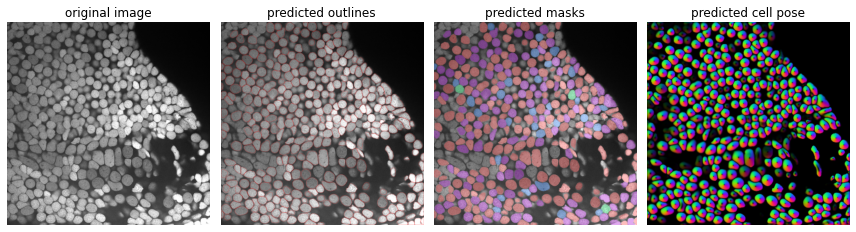

Diameter 90, threshold 0, iso 1
2022-02-26 16:48:16,576 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:48:18,464 [INFO] >>>> TOTAL TIME 1.89 sec


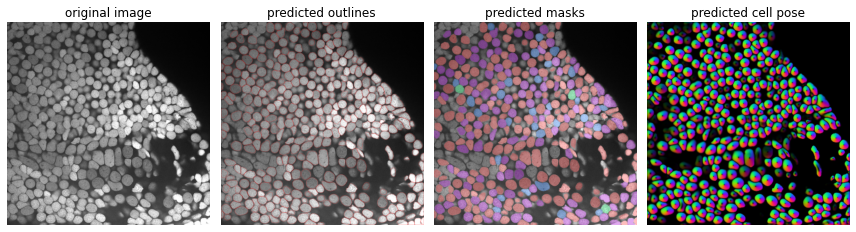

Diameter 90, threshold 0, iso 2
2022-02-26 16:48:21,505 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:48:23,375 [INFO] >>>> TOTAL TIME 1.87 sec


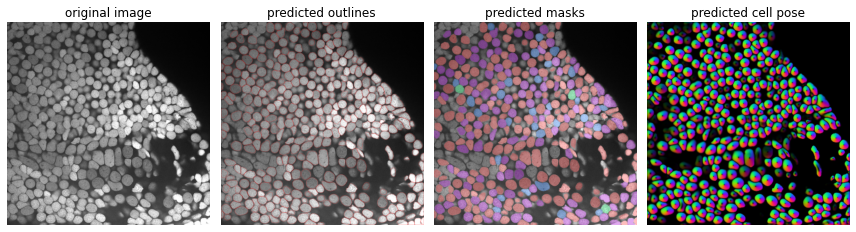

Diameter 90, threshold 0, iso 3
2022-02-26 16:48:26,446 [INFO] ~~~ FINDING MASKS ~~~
2022-02-26 16:48:28,326 [INFO] >>>> TOTAL TIME 1.88 sec


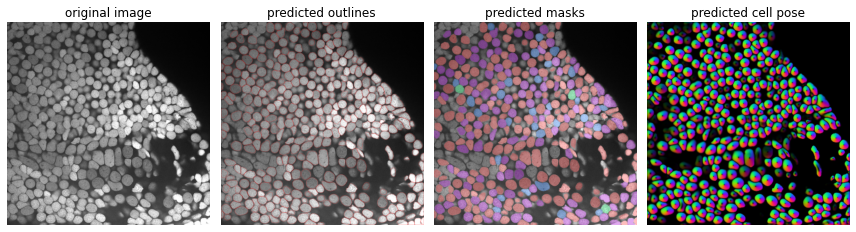

Diameter 90, threshold 1, iso 0
2022-02-26 16:48:31,409 [INFO] ~~~ FINDING MASKS ~~~


KeyboardInterrupt: 

In [14]:
diamters = [90,100,110]
thresholds = [-2,-1,0,1,2]
isotropy = [0,1,2,3]

for vol in cfg.VOLUMES[1:]:
    img0_100 = load_vol(cfg.ROOT, vol)[100, : , :]
    for d in diamters:
        for t in thresholds:
            for i in isotropy:
                print(f"Diameter {d}, threshold {t}, iso {i}")
                #print(f"threshold {t}")
                masks, flows, styles, diams = model.eval(img0_100, diameter=d, anisotropy=i, mask_threshold=t, invert=False, channels=channels)
                #vis_sample(img0_100, masks, flows, save=False, path=os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/cellpose_ouput", vol.split(".")[0]+"_d_"+str(d)+"_t_"+ str(t)+".png"))
                vis_sample(img0_100, masks, flows)#, save=True, path=os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/cellpose_ouput", vol.split(".")[0]+"_d_"+str(d)+"_t_"+ str(t)+".png"))

# Estimate cell size in pixel

In [ ]:
# retrive sample image
img = np.asarray(vol[100, : , :]).astype(np.uint8)
print(img.shape)

# stack to three channels
img = np.stack((img,)*3, axis=-1)

# estimate cell size
BLOCKSIZE = (95,95)

# grid lines at these intervals (in pixels)
dx, dy = BLOCKSIZE
    
# divide the image shape in to tiles
ys = int(img.shape[0] // dy)
xs = int(img.shape[1] // dx)    

# setup the ticks and labels for the x axis
x_ticks = [BLOCKSIZE[1]*i for i in range (0,xs)]
x_labels = [i for i in range (0,xs)]

# setup the ticks and labels for the y axis
y_ticks = [BLOCKSIZE[0]*i for i in range (0,ys)]
y_labels = [i for i in range (0,ys)]

# colors
grid_color_green = [0,100,0]
grid_color_red = [255,0,0]

# Modify the image to include the grid
img[:,::dy,:] = grid_color_green
img[::dx,:,:] = grid_color_green

# color in sample cells
img = color_grid_box(img,BLOCKSIZE,10,11,12,13,color=grid_color_red)
img = color_grid_box(img,BLOCKSIZE,13,14,16,17,color=grid_color_red)
img = color_grid_box(img,BLOCKSIZE,14,15,19,20,color=grid_color_red)
img = color_grid_box(img,BLOCKSIZE,4,5,8,9,color=grid_color_red)

fig, axes = plt.subplots(ncols=1,nrows=1, figsize=(20,20))

axes.set_xticks(x_ticks)
axes.set_xticklabels(x_labels)
axes.set_yticks(y_ticks)
axes.set_yticklabels(y_labels) 
axes.imshow(img)
